<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук ВШЭ, программист-исследователь Mail.ru Group  Юрий Кашницкий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 4. Обучение с учителем. Методы классификации
## <center>Практика. Переобучение, кривые валидации и обучения. Решение

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%pylab inline
figsize(12, 8)
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../../scripts/')
from load_titanic_with_features import load_titanic

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train, y, X_test, = load_titanic("../../data/titanic_train.csv",
                                       "../../data/titanic_test.csv")

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
def plot_curve(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

In [5]:
def plot_learning_curve(C=1):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(SVC(C=C),
                                                  X_train_scaled, y, 
                                                  train_sizes, cv=5)
    plot_curve(N_train, 1 - val_train, label='training scores')
    plot_curve(N_train, 1 - val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('error')
    plt.ylim(0, 0.4)
    plt.xlim(5, 800)
    plt.legend()

In [6]:
%%time
c_values = np.logspace(-3, 2, 40)
val_train, val_test = validation_curve(SVC(), X_train_scaled, y,
                                       'C', c_values, cv=5)

CPU times: user 4.64 s, sys: 9.82 ms, total: 4.65 s
Wall time: 4.65 s


In [7]:
validation_curve?

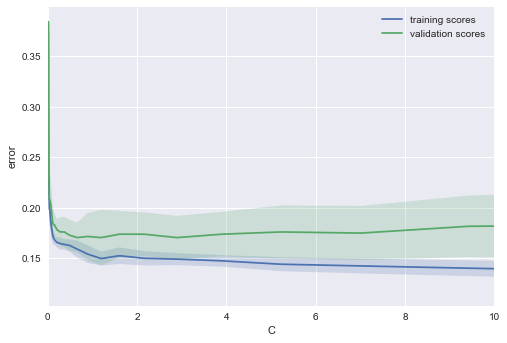

In [8]:
plot_curve(c_values, 1 - val_train, label='training scores')
plot_curve(c_values, 1 - val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('error')
plt.legend()
plt.xlim((0,10));

**Теперь то же самое, но для 100 значений C от 0.05 до 5. Проделайте это для масштабированной и не масштабированной выборки и сравните результаты.**

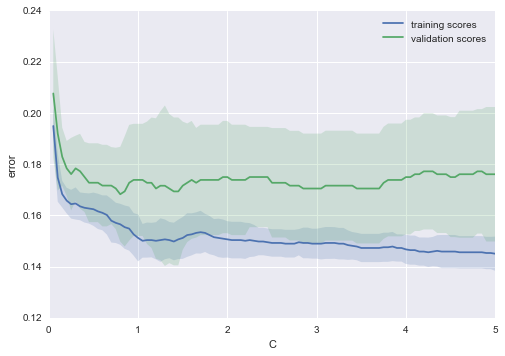

In [9]:
c_values = np.linspace(0.05, 5, 100)
val_train, val_test = validation_curve(SVC(), X_train_scaled, y,
                                       'C', c_values, cv=5)
plot_curve(c_values, 1 - val_train, label='training scores')
plot_curve(c_values, 1 - val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('error')
plt.legend();

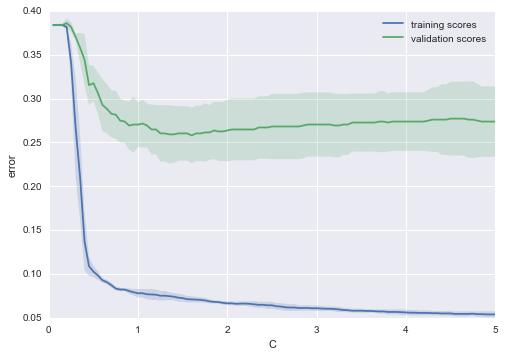

In [12]:
c_values = np.linspace(0.05, 5, 100)
val_train, val_test = validation_curve(SVC(), X_train, y,
                                       'C', c_values, cv=5)
plot_curve(c_values, 1 - val_train, label='training scores')
plot_curve(c_values, 1 - val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('error')
plt.legend();

**Найдите оптимальное значение параметра C из диапазона от 0.05 до 3 с помощью GridSearchCV.**

In [10]:
from sklearn.grid_search import GridSearchCV
# params for grid search
params = {'C': np.linspace(0.05, 3, 100)}

# make an instance of a grid searcher
best_clf = GridSearchCV(SVC(), 
                        params, verbose=True, n_jobs=4)

# fit X and y (train set and corresponding labels) to the grid searcher
best_clf.fit(X_train_scaled, y)

# print best estimatior and params
print("Best params:", best_clf.best_params_)
print("Best cross validation accuracy", best_clf.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best params: {'C': 2.1358585858585859}
Best cross validation accuracy 0.838383838384


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.3s finished


**Посмотрите на кривые обучения для значений C $10^{-4}, 10^6$, а также для лучшего найденного с помощью GridSearchCV.**

In [9]:
plot_learning_curve?

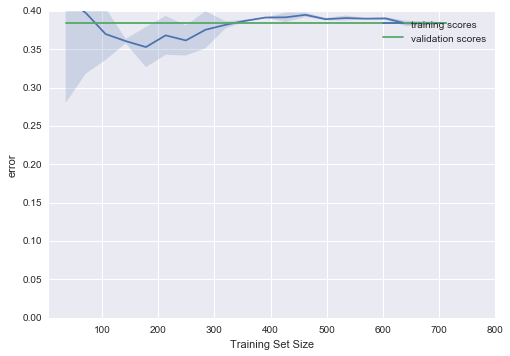

In [11]:
plot_learning_curve(C=1e-4) # недообучение

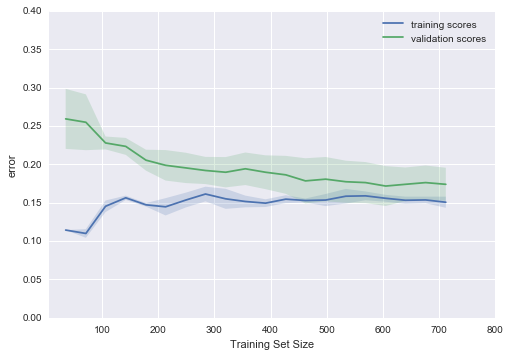

In [13]:
plot_learning_curve(best_clf.best_params_['C']) # хорошо

CPU times: user 1min 4s, sys: 148 ms, total: 1min 5s
Wall time: 1min 5s


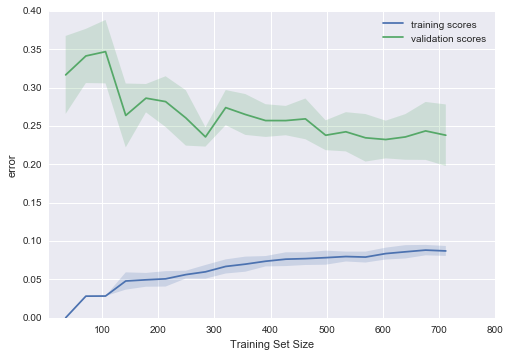

In [16]:
%%time
plot_learning_curve(1e4) # переобучение

In [13]:
# make predictions. This results in 0.7847 LB
predicted_labels = best_clf.predict(X_test_scaled)

# turn predictions into data frame and save as csv file
predicted_df = pd.DataFrame(predicted_labels,
                            index = np.arange(892, 892 + X_test_scaled.shape[0]),
                            columns=["Survived"])
predicted_df.to_csv("../../output/titanic_simple_svm.csv", index_label="PassengerId")